# Before you start

* Make sure to add shortcut to **Day8_Visual_Odometry** to your own drive
* Make sure to make a copy of this file in your own drive.
* You need to add codes where marked by **#TODO**

# Reference Materials
* [Multi View Geometry - Richard Hartley and Andrew Zisserman](https://users.cecs.anu.edu.au/~hartley/Papers/CVPR99-tutorial/tutorial.pdf)
* [Slides on Multi View Geometry](https://users.cecs.anu.edu.au/~hartley/Papers/CVPR99-tutorial/tutorial.pdf)
* [Introduction to Linear Algebra - Gilbert Strang](http://students.aiu.edu/submissions/profiles/resources/onlineBook/Y5B7M4_Introduction_to_Linear_Algebra-_Fourth_Edition.pdf)
* [Probabilistic Robotics - Sebastian Thrun](https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf)
* [ORB_SLAM3](https://github.com/UZ-SLAMLab/ORB_SLAM3)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import tqdm
import plotly.express as px
import plotly.graph_objects as go

# Get Dataset

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [17]:
# Sanity Check
try:
  files = os.listdir('/gdrive/MyDrive/Day8_Visual_Odometry')
  print(f"Following files are available: {files}")
  print("You are good to go 🙂")
except:
  print('Dataset is not available 😟. Please check if there is a dir "Day8_Visual_Odometry" in your google drive.')

Following files are available: ['Tiny_NeRF_ANAIS.ipynb', 'kitti.tar.xz', 'depths.txt', 'NERF Original Paper.pdf', 'Visual-SLAM.pdf', 'Visual_Odometry.ipynb']
You are good to go 🙂


In [18]:
# Extract kitti dataset
!mkdir kitti
!tar -xJf /gdrive/MyDrive/Day8_Visual_Odometry/kitti.tar.xz -C kitti

mkdir: cannot create directory ‘kitti’: File exists


In [19]:
# Get the list of image paths
frames = glob.glob("kitti/*.png")
frames.sort()

if len(frames)==0:
  print("There are no images 😟! You must have messed up the PATH!!!")
else:
  print(f"{len(frames)} frames available! You are good to go 🙂")

3001 frames available! You are good to go 🙂


# Utility Functions

In [20]:
def show_image(img):
  fig = plt.gcf()
  fig.set_size_inches(25,25)
  plt.imshow(img)

def estimate_relative_pose(extractor, frame_1, frame_2, cam_mat):
    kpts_1, descs_1 = extractor.detectAndCompute(frame_1, None)
    kpts_2, descs_2 = extractor.detectAndCompute(frame_2, None)

    matches = matcher.knnMatch(descs_1, descs_2, k=2)

    RATIO = 0.8
    good = []
    matched_kpts_1, matched_kpts_2 = [], []
    for (m1, m2) in matches: # for every descriptor, take closest two matches
        if m1.distance < RATIO * m2.distance: # best match has to be this much closer than second best
            good.append(m1)
            matched_kpts_1.append(kpts_1[m1.queryIdx].pt)
            matched_kpts_2.append(kpts_2[m2.trainIdx].pt)
    matched_kpts_1 = np.array(matched_kpts_1, dtype=np.float32)
    matched_kpts_2 = np.array(matched_kpts_2, dtype=np.float32)

    E, mask = cv2.findEssentialMat(
    matched_kpts_2, matched_kpts_1,
    cam_mat,
    method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, matched_kpts_2, matched_kpts_1, cam_mat)

    mask = (mask > 0)[..., 0]
    matched_kpts_1 = matched_kpts_1[mask]
    matched_kpts_2 = matched_kpts_2[mask]

    return R, t, matched_kpts_1, matched_kpts_2

def triangulate_3d_points(
    points_1, points_2, 
    intrinsic_matrix, 
    R1, t1, R2, t2
    ):
    R_t_old = np.zeros([3,4], dtype=np.float32)
    R_t_old[..., :-1] = R1
    R_t_old[..., -1] = t1
    cam_old = cam_mat @ R_t_old

    R_t_new = np.zeros([3,4], dtype=np.float32)
    R_t_new[..., :-1] = R2
    R_t_new[..., -1] = t2
    cam_new = cam_mat @ R_t_new

    triangulated_points_homogeneous = cv2.triangulatePoints(
        cam_old, cam_new, 
        points_1.T, points_2.T
    ).T

    triangulated_points = triangulated_points_homogeneous[..., :-1] / triangulated_points_homogeneous[..., [-1]]

    distances = np.linalg.norm(triangulated_points - t1, axis=1)
    triangulated_points = triangulated_points[distances < 10.0]

    camera_axis = np.array([0,0,-1]).T
    dots = (R_1 @ camera_axis).dot(triangulated_points.T)
    mask_from_dots = dots > 0.0

    return triangulated_points[mask_from_dots]

def get_ground_truth_scales(ground_truth_scales_file):
    scales = []
    last_t = None
    for line in ground_truth_scales_file:
        Rt = np.fromstring(line, sep=' ')
        Rt = Rt.reshape(3,4)
        R = Rt[:, :3]
        t = Rt[:, 3]
        if last_t is not None:
            scales.append(
                np.linalg.norm(t - last_t)
            )
        last_t = t
    return scales

# Step 1: Feature Extraction

In [32]:
# Define a feature extractor
feature_extractor = cv2.ORB_create(nfeatures=4096)


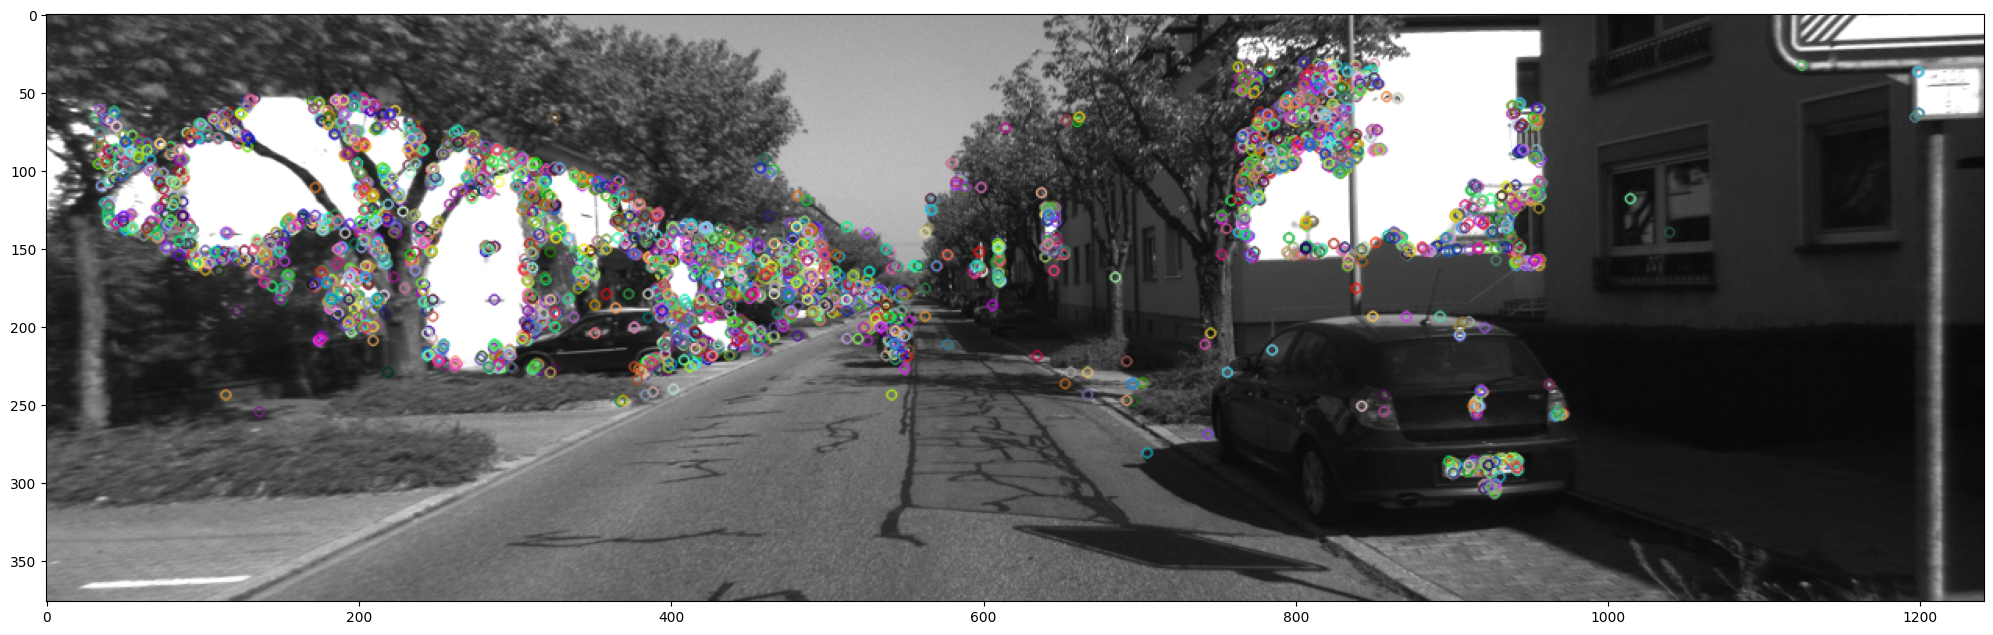

In [22]:
# Read first frame
frame_0 = cv2.imread(frames[0])

# Convert to Grayscale
frame_0 = cv2.cvtColor(frame_0, cv2.COLOR_BGR2GRAY)

# Detect Keypoint in the frame with descriptors
keypoints_0, descriptors_0 = feature_extractor.detectAndCompute(frame_0,None)

# Draw Keypoints on the frame image
frame_0_with_keypoints = cv2.drawKeypoints(frame_0, keypoints_0, None, flags=0)

# Show the frame with keypoints
show_image(frame_0_with_keypoints)

# Step 2: Feature Matching

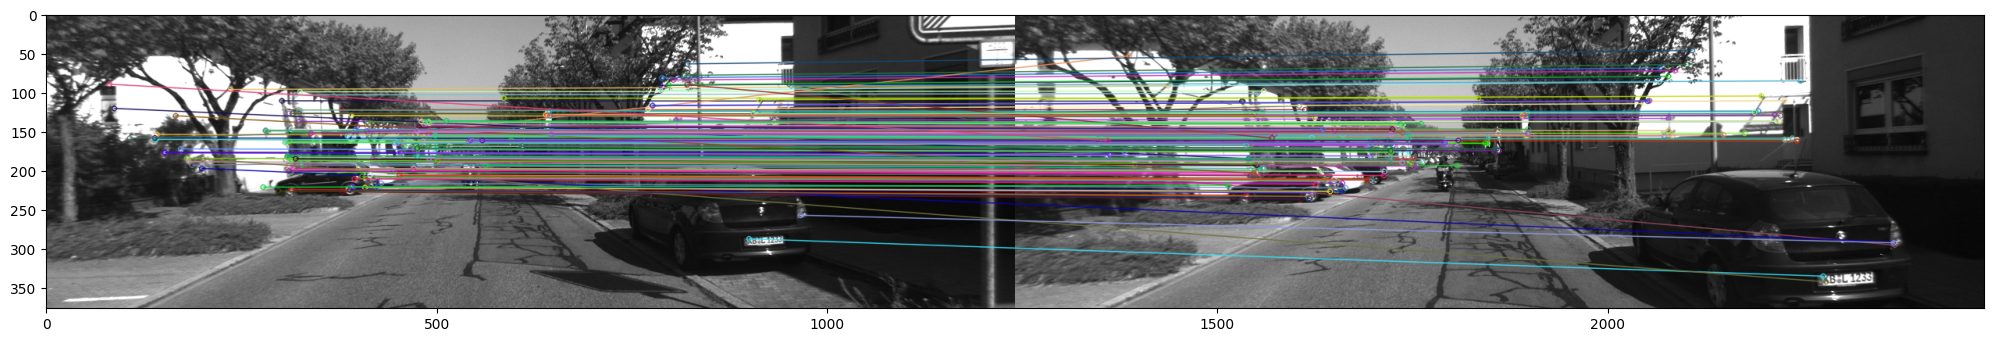

In [23]:
# with the name image.jpg  
# TODO: Read frames[3], similar to frames[0] above
frame_3 = cv2.imread(frames[3])

# TODO: Get keypoints_3, descriptors_3  for frame_3
keypoints_3, descriptors_3 =feature_extractor.detectAndCompute(frame_3,None)

  
# Define Matcher
matcher = cv2.BFMatcher()

# Match keypoints in frame 1 and 3
matches = matcher.knnMatch(descriptors_0, descriptors_3, k=2)

# Apply Ratio Test
# TODO: Try with ratios: 0.6. 0.7, 0.8, 0.9, 1
RATIO = 0.8
good_matches = []
for (m1, m2) in matches: # for every descriptor, take closest two matches
    if m1.distance < RATIO * m2.distance: # best match has to be this much closer than second best
        good_matches.append(m1)

good_matches = sorted(good_matches, key = lambda x:x.distance)
   
# Plot the matches
image_with_matches = cv2.drawMatches(frame_0, keypoints_0, frame_3, keypoints_3, good_matches[:200], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  
# Show matcheshow_image(image_with_matches)

# Step 3: Visual Odometry

In [34]:
# Pre-defined camera intrinsics
cam_mat = np.array([
    [7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02],
    [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02],
    [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00],
])

# Load Ground truth scales
gts = get_ground_truth_scales(open("/gdrive/MyDrive/Day8_Visual_Odometry/depths.txt"))

# Define number of images to use
# TODO You can change the number of images, max=3000
# Single frame can take up to 3 sec
no_of_images = 50

# Read initial frame
frame_1 = cv2.imread(frames[0])

# Initial Pose is identity
R_id = np.eye(3)
t_id = np.array([0,0,0], dtype=np.float32)

R_1 = R_id.copy()
t_1 = t_id.copy()

# For the collect of Poses, Depths and 3D point clouds
ts = []
Rs = []
dts = []
point_cloud_map = []

print(f"Running Visual Odometry for {no_of_images} images...")
for image_file_name, ground_truth_scale in tqdm.tqdm(zip(frames[1:no_of_images], gts)):

    # Get the next frame
    frame_2 =cv2.imread(image_file_name)
    frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY)
    print(frame_2)
     #TODO read image from "image_file_name"

    # TODO: Estimate relative pose between the two frames 
    # "estimate_relative_pose" function is available
    # Parameters:
    # 1. Feature Extractor
    # 2. First Frame
    # 3. Second Frame
    # 4. Camera intrinsic matrix
    dR, dt, points_1, points_2 = estimate_relative_pose(feature_extractor,frame_1,frame_2,cam_mat)

    dt = dt[...,0] * ground_truth_scale
    dts.append(dt)

    # Get absolute pose of this frame
    R_2 = dR.dot(R_1)
    t_2 = t_1 + R_1.dot(dt)

    # TODO: Triangulation
    # Function "triangulate_3d_points" is provided
    # Parameters: 
    # 1. Points from first image
    # 2. Points from second image
    # 3. Camera intrinsic matrix
    # 4. Identity rotation matrix
    # 5. Identity translation vector
    # 6. Relative rotation matrix-
    # 7. Relative translation vector_1_
    triangulated_points = triangulate_3d_points(points_1,points_2,cam_mat,R_id,t_id,dR,dt)


    triangulated_points = (R_2 @ triangulated_points.T).T
    triangulated_points += t_2

    # Collect the Poses and 3D point clouds
    point_cloud_map.append(triangulated_points)
    ts.append(t_2)
    Rs.append(R_2)

    # Prepare for next loop
    t_1 = t_2
    R_1 = R_2
    frame_1 = frame_2

ts = np.array(ts)
dts = np.array(dts)
point_cloud_map_concatted = np.concatenate(point_cloud_map)

print(f"{point_cloud_map_concatted.shape[0]} 3D points has been triangulated.")

Running Visual Odometry for 50 images...


0it [00:00, ?it/s]

[[ 50  47  50 ...  77  81  84]
 [ 51  47  50 ... 123 135 147]
 [ 55  54  53 ... 135 157 177]
 ...
 [143 146 142 ...  26  26  25]
 [140 130 130 ...  23  24  24]
 [136 136 138 ...  22  23  23]]


1it [00:00,  1.01it/s]

[[ 51  53  51 ...  41  42  42]
 [ 49  57  62 ...  42  42  40]
 [ 48  53  60 ...  42  42  41]
 ...
 [159 157 152 ...  25  25  24]
 [151 147 148 ...  22  21  21]
 [153 157 158 ...  21  20  22]]


2it [00:01,  1.32it/s]

[[ 51  56  57 ...  40  40  41]
 [ 55  52  52 ...  38  40  41]
 [ 61  54  49 ...  41  40  40]
 ...
 [144 143 143 ...  23  22  22]
 [142 139 142 ...  22  21  22]
 [147 147 149 ...  22  22  22]]


3it [00:02,  1.42it/s]

[[ 62  69  72 ...  41  41  39]
 [ 66  66  64 ...  40  39  39]
 [ 66  64  62 ...  40  39  38]
 ...
 [127 129 132 ...  18  17  17]
 [135 132 127 ...  18  18  18]
 [144 140 135 ...  19  19  19]]


4it [00:03,  1.23it/s]

[[48 41 38 ... 39 40 40]
 [37 34 33 ... 39 38 39]
 [43 40 35 ... 38 38 38]
 ...
 [72 63 50 ... 33 32 31]
 [54 46 42 ... 32 32 30]
 [51 50 53 ... 30 30 28]]


5it [00:04,  1.16it/s]

[[80 73 66 ... 39 38 37]
 [84 71 64 ... 39 39 39]
 [87 86 81 ... 40 41 41]
 ...
 [86 82 74 ... 58 49 46]
 [72 68 64 ... 49 49 49]
 [72 67 63 ... 36 41 46]]


6it [00:05,  1.11it/s]

[[61 63 63 ... 38 38 39]
 [41 40 41 ... 40 39 38]
 [60 58 56 ... 41 39 39]
 ...
 [82 89 95 ...  6  8 10]
 [96 96 91 ...  8  8 10]
 [91 87 82 ...  9 10  9]]


7it [00:05,  1.25it/s]

[[64 55 50 ... 44 43 41]
 [53 55 56 ... 44 42 42]
 [56 55 55 ... 40 44 45]
 ...
 [74 67 61 ...  8  8  9]
 [76 75 74 ... 14 14 12]
 [82 82 78 ... 13 15 14]]


8it [00:06,  1.36it/s]

[[ 30  35  42 ... 255 255 255]
 [ 28  32  37 ... 255 255 255]
 [ 30  31  33 ... 255 255 255]
 ...
 [120 119 121 ...  12  12  12]
 [116 116 116 ...  12  12  12]
 [118 121 123 ...  12  12  11]]


9it [00:06,  1.44it/s]

[[244 229 207 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [136 132 128 ...  21  20  21]
 [133 129 124 ...  22  21  19]
 [136 135 131 ...  21  21  22]]


10it [00:07,  1.50it/s]

[[232 255 255 ... 219 255 255]
 [207 253 255 ... 227 254 255]
 [182 242 255 ... 231 252 255]
 ...
 [121 117 122 ...  45  40  31]
 [129 132 132 ...  49  52  49]
 [133 128 124 ...  44  47  50]]


11it [00:08,  1.55it/s]

[[ 74  61  55 ... 177 122  94]
 [ 44  51  58 ... 171 122  93]
 [ 52  55  61 ... 170 125  90]
 ...
 [136 131 128 ...  66  62  58]
 [135 135 136 ...  70  73  71]
 [152 153 149 ...  66  72  68]]


12it [00:08,  1.58it/s]

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [122 120 118 ...  20  20  21]
 [120 121 128 ...  27  21  21]
 [117 118 121 ...  47  36  29]]


13it [00:09,  1.60it/s]

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [151 145 136 ...  42  39  35]
 [125 120 118 ...  45  43  38]
 [106 111 119 ...  43  50  48]]


14it [00:09,  1.62it/s]

[[244 205 163 ... 255 255 255]
 [248 210 173 ... 251 255 255]
 [254 225 188 ... 213 240 255]
 ...
 [ 67  67  65 ...  25  28  32]
 [ 79  84  86 ...  21  22  25]
 [100 100  90 ...  20  21  21]]


15it [00:10,  1.63it/s]

[[227 217 222 ... 255 255 255]
 [253 250 253 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [ 87  92  94 ...  34  35  35]
 [ 89  90  84 ...  32  31  30]
 [ 85  87  90 ...  31  30  29]]


16it [00:11,  1.64it/s]

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [104 102 106 ...  31  31  31]
 [110 123 131 ...  32  31  30]
 [112 116 120 ...  31  31  30]]


17it [00:11,  1.65it/s]

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [139 143 143 ...  31  32  32]
 [136 133 132 ...  28  29  30]
 [137 142 146 ...  30  29  26]]


18it [00:12,  1.66it/s]

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [150 149 146 ...  31  30  30]
 [143 141 137 ...  31  29  28]
 [142 144 145 ...  31  32  31]]


19it [00:12,  1.67it/s]

[[ 83  81  84 ...  52  53  52]
 [ 85  85  86 ...  55  54  53]
 [ 85  86  85 ...  53  53  52]
 ...
 [150 153 155 ...  26  26  25]
 [159 154 144 ...  28  27  26]
 [156 152 151 ...  28  29  26]]


20it [00:13,  1.66it/s]

[[255 255 255 ...  50  51  51]
 [255 255 255 ...  49  51  52]
 [255 255 255 ...  50  50  50]
 ...
 [171 177 176 ...  17  18  18]
 [161 163 160 ...  16  17  18]
 [171 170 171 ...  19  19  17]]


21it [00:14,  1.67it/s]

[[255 255 255 ...  27  28  29]
 [255 255 255 ...  27  29  29]
 [255 255 255 ...  26  25  24]
 ...
 [156 155 156 ...  18  17  17]
 [165 161 158 ...  18  17  15]
 [154 154 155 ...  18  17  17]]


22it [00:14,  1.67it/s]

[[255 255 255 ...  32  29  27]
 [255 255 255 ...  32  29  27]
 [255 255 255 ...  33  30  28]
 ...
 [153 159 162 ...  84  78  69]
 [151 151 148 ...  81  79  68]
 [156 155 158 ...  64  73  75]]


23it [00:15,  1.59it/s]

[[ 69  67  69 ...  59  57  55]
 [ 71  72  70 ...  58  59  57]
 [ 70  72  71 ...  59  59  58]
 ...
 [160 165 168 ...  25  26  27]
 [184 190 192 ...  44  41  35]
 [182 182 188 ...  54  56  51]]


24it [00:16,  1.39it/s]

[[ 63  56  56 ...  27  32  40]
 [ 63  55  50 ...  28  32  37]
 [ 63  54  46 ...  28  29  35]
 ...
 [171 171 168 ...  53  58  55]
 [171 172 176 ...  38  44  54]
 [156 158 162 ...  51  48  51]]


25it [00:17,  1.28it/s]

[[ 37  37  37 ...  27  27  27]
 [ 36  35  37 ...  23  25  25]
 [ 36  36  38 ...  22  24  26]
 ...
 [191 196 193 ...  22  23  23]
 [182 180 177 ...  23  22  22]
 [187 189 185 ...  24  22  22]]


26it [00:18,  1.21it/s]

[[255 255 255 ...  59  60  60]
 [255 255 255 ...  60  59  59]
 [255 255 255 ...  63  62  60]
 ...
 [172 175 174 ...  25  24  25]
 [172 175 170 ...  25  24  23]
 [167 164 162 ...  25  24  24]]


27it [00:18,  1.32it/s]

[[255 255 255 ...  60  58  57]
 [255 255 255 ...  59  58  58]
 [255 255 255 ...  58  60  61]
 ...
 [ 21  20  20 ...  26  25  24]
 [ 21  21  21 ...  23  23  24]
 [ 22  23  23 ...  24  23  23]]


28it [00:19,  1.41it/s]

[[82 82 83 ... 32 34 34]
 [82 78 80 ... 35 36 37]
 [84 86 87 ... 35 37 38]
 ...
 [27 27 26 ... 20 22 24]
 [25 25 26 ... 21 21 20]
 [25 26 27 ... 24 24 23]]


29it [00:20,  1.48it/s]

[[255 255 255 ...  22  23  26]
 [255 255 255 ...  25  28  31]
 [255 255 255 ...  31  31  32]
 ...
 [ 71  70  76 ...  23  23  24]
 [ 80  79  79 ...  23  22  23]
 [ 74  71  77 ...  20  21  22]]


30it [00:20,  1.53it/s]

[[255 255 255 ...  60  59  59]
 [255 255 255 ...  56  57  59]
 [255 255 255 ...  55  57  59]
 ...
 [ 59  61  68 ...  21  22  22]
 [ 88  92 107 ...  24  24  22]
 [104 110 119 ...  24  24  22]]


31it [00:21,  1.58it/s]

[[255 255 255 ...  51  51  52]
 [255 255 255 ...  52  54  53]
 [255 255 255 ...  53  51  51]
 ...
 [185 188 189 ...  25  24  24]
 [169 177 180 ...  22  22  22]
 [184 191 193 ...  22  22  21]]


32it [00:21,  1.61it/s]

[[120 117 115 ...  17  18  20]
 [118 117 122 ...  20  19  16]
 [127 119 115 ...  17  16  18]
 ...
 [176 183 187 ...  21  21  20]
 [183 181 178 ...  21  21  21]
 [195 194 196 ...  23  22  21]]


33it [00:22,  1.63it/s]

[[255 255 250 ...  49  44  36]
 [255 255 255 ...  50  46  40]
 [255 255 255 ...  49  44  37]
 ...
 [192 185 181 ...  24  24  23]
 [169 165 167 ...  24  24  22]
 [187 194 194 ...  23  23  23]]


34it [00:23,  1.56it/s]

[[ 53  62  64 ...  51  50  49]
 [ 46  51  58 ...  51  53  52]
 [ 43  48  49 ...  51  49  49]
 ...
 [179 183 186 ...  18  18  18]
 [169 170 167 ...  17  16  15]
 [160 161 168 ...  16  15  15]]


35it [00:23,  1.59it/s]

[[176 189 192 ...  30  25  21]
 [165 173 190 ...  33  27  21]
 [123 127 141 ...  31  25  20]
 ...
 [198 196 201 ...  12  11  11]
 [198 205 206 ...  12  11  11]
 [195 196 197 ...  15  14  14]]


36it [00:24,  1.62it/s]

[[100  77  54 ...  13  13  14]
 [140  97  62 ...  12  13  13]
 [178 138  89 ...  10  11  13]
 ...
 [ 12  11  12 ...  16  18  19]
 [ 13  14  12 ...  17  17  18]
 [ 13  12  12 ...  15  15  16]]


37it [00:24,  1.64it/s]

[[113 111 105 ...  20  16  15]
 [120  98  82 ...  20  18  17]
 [166 136 102 ...  24  23  20]
 ...
 [ 13  13  11 ...  19  19  17]
 [ 13  13  12 ...  18  18  19]
 [ 11  11  12 ...  18  17  17]]


38it [00:25,  1.64it/s]

[[ 31  32  34 ...  18  19  17]
 [ 39  41  39 ...  18  17  16]
 [ 48  51  54 ...  16  15  16]
 ...
 [151 151 146 ...  19  18  19]
 [154 157 162 ...  18  17  16]
 [185 190 195 ...  20  19  19]]


39it [00:26,  1.65it/s]

[[ 43  38  28 ...  29  32  33]
 [ 40  39  31 ...  30  33  33]
 [ 32  32  32 ...  29  29  29]
 ...
 [161 164 167 ...   9  10  10]
 [176 179 179 ...   8   9   9]
 [174 172 173 ...   7   8   8]]


40it [00:26,  1.65it/s]

[[ 76  80  84 ...  37  37  39]
 [ 72  77  81 ...  36  38  37]
 [ 69  67  70 ...  33  32  29]
 ...
 [139 143 148 ...   8   8   8]
 [147 153 157 ...   8   8   8]
 [116 120 127 ...   9   9   8]]


41it [00:27,  1.65it/s]

[[71 70 72 ... 34 35 35]
 [69 69 69 ... 35 35 34]
 [68 67 67 ... 29 29 29]
 ...
 [73 70 69 ... 12 12 12]
 [68 74 78 ... 11 11 11]
 [83 86 87 ... 11 11 11]]


42it [00:27,  1.65it/s]

[[60 61 60 ... 50 49 48]
 [45 45 45 ... 47 49 49]
 [40 41 40 ... 52 50 47]
 ...
 [61 54 52 ... 11 11 10]
 [46 42 43 ... 11 10  9]
 [52 53 58 ... 11 11 10]]


43it [00:28,  1.56it/s]

[[ 84  85  86 ...  52  52  51]
 [ 86  88  90 ...  52  52  51]
 [ 98  96  98 ...  53  52  51]
 ...
 [188 189 186 ...   9   9   9]
 [176 169 170 ...   8   9   9]
 [162 162 165 ...   8   8   9]]


44it [00:29,  1.38it/s]

[[255 255 255 ...  15  12   9]
 [255 255 255 ...  10  10   9]
 [255 255 255 ...  10  13  18]
 ...
 [176 183 182 ...  14  14  14]
 [190 181 169 ...  15  15  15]
 [168 163 161 ...  14  15  15]]


45it [00:30,  1.26it/s]

[[255 255 255 ...  32  29  27]
 [255 255 255 ...  33  31  28]
 [255 255 255 ...  32  31  29]
 ...
 [177 180 188 ...  17  18  19]
 [186 188 186 ...  16  16  16]
 [179 181 180 ...  18  19  18]]


46it [00:31,  1.21it/s]

[[244 240 243 ...  48  47  46]
 [248 245 244 ...  49  49  49]
 [247 251 251 ...  50  48  45]
 ...
 [181 180 185 ...  18  18  18]
 [181 181 179 ...  18  18  17]
 [175 175 172 ...  19  19  18]]


47it [00:31,  1.32it/s]

[[227 232 231 ...  26  26  26]
 [236 229 223 ...  26  28  28]
 [244 240 237 ...  26  27  26]
 ...
 [163 171 175 ...  19  20  20]
 [172 177 174 ...  18  18  18]
 [163 162 165 ...  17  18  17]]


48it [00:32,  1.41it/s]

[[ 51  50  51 ...   5   6   5]
 [ 51  49  53 ...   5   5   6]
 [ 55  53  51 ...   5   6   5]
 ...
 [176 175 166 ...  10  11  11]
 [157 156 152 ...  11  11  11]
 [162 166 171 ...  11  10   9]]


49it [00:33,  1.48it/s]

13145 3D points has been triangulated.


# Step 4: Visualization

In [36]:
fig1 = px.scatter_3d(point_cloud_map_concatted, x=0, y=2, z=1)
fig1.update_traces(marker={'size': 1})

camera_axes = [R.T @ np.array([0,0,-1]).T for R in Rs] 
camera_axes = np.array(camera_axes)

fig2 = go.Figure(data=go.Cone(
    x=ts[..., 0],
    y=ts[..., 2],
    z=ts[..., 1],
    u=dts[..., 0],
    v=dts[..., 2],
    w=dts[..., 1],
    sizemode="absolute",
    sizeref=3,
    anchor="tail"))

go.Figure(data=fig1.data + fig2.data).show()